# Import relevant libraries

In [26]:
import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# Image Preprocessing (1)

### a. Crop faces of images with 2 visible eyes
### b. loop through dataset and save cropped faces in a new cropped folder

In [3]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

In [4]:
def get_cropped_face_if_2_eyes(img_path):
    img = cv2.imread(img_path)
    if img is not None:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        face = face_cascade.detectMultiScale(gray_img, 1.3, 5)
        for (x,y,w,h) in face:
            roi_img = img[y:y+h, x:x+w]
            roi_gray = gray_img[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes)>= 2:
                return roi_img

In [5]:
path_to_dataset = './dataset/'
path_to_cropped_dataset = './dataset/cropped/'

In [6]:
import os
img_dirs = []
for entry in os.scandir(path_to_dataset):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [7]:
img_dirs

['./dataset/cristiano_ronaldo',
 './dataset/heung_min_son',
 './dataset/lionel_messi',
 './dataset/mohammed_salah',
 './dataset/neymar_jr',
 './dataset/sadio_mane']

In [8]:
import shutil
if os.path.exists(path_to_cropped_dataset):
    shutil.rmtree(path_to_cropped_dataset)
os.mkdir(path_to_cropped_dataset)

In [9]:
cropped_img_dirs = []
for img_dir in img_dirs:
    player_name = img_dir.split('/') [-1]
    count = 1
    for file in os.scandir(img_dir):
        roi = get_cropped_face_if_2_eyes(file.path)
        if roi is not None:
            cropped_folder = path_to_cropped_dataset + player_name
            if not os.path.exists(cropped_folder):
                os.mkdir(cropped_folder)
                cropped_img_dirs.append(cropped_folder)
                print('Generating cropped images in folder: ' + cropped_folder)
            file_name = player_name + str(count) + '.png'
            cropped_file_path = cropped_folder + '/' + file_name
            cv2.imwrite(cropped_file_path, roi)            
            count+=1
                

Generating cropped images in folder: ./dataset/cropped/cristiano_ronaldo
Generating cropped images in folder: ./dataset/cropped/heung_min_son
Generating cropped images in folder: ./dataset/cropped/lionel_messi
Generating cropped images in folder: ./dataset/cropped/mohammed_salah
Generating cropped images in folder: ./dataset/cropped/neymar_jr
Generating cropped images in folder: ./dataset/cropped/sadio_mane


# Image preprocessing (2)
## Manually remove unwanted images and add all cropped images path to a dictionary

In [2]:
cropped_img_dict = {}
for img_dir in cropped_img_dirs:
    player_name = img_dir.split('/')[-1]
    img_list = []
    for img in os.scandir(img_dir):
        img_list.append(img.path)
    cropped_img_dict[player_name]= img_list
cropped_img_dict

{'cropped\\cristiano_ronaldo': ['./dataset/cropped\\cristiano_ronaldo\\cristiano_ronaldo1.png',
  './dataset/cropped\\cristiano_ronaldo\\cristiano_ronaldo10.png',
  './dataset/cropped\\cristiano_ronaldo\\cristiano_ronaldo100.png',
  './dataset/cropped\\cristiano_ronaldo\\cristiano_ronaldo11.png',
  './dataset/cropped\\cristiano_ronaldo\\cristiano_ronaldo12.png',
  './dataset/cropped\\cristiano_ronaldo\\cristiano_ronaldo13.png',
  './dataset/cropped\\cristiano_ronaldo\\cristiano_ronaldo14.png',
  './dataset/cropped\\cristiano_ronaldo\\cristiano_ronaldo15.png',
  './dataset/cropped\\cristiano_ronaldo\\cristiano_ronaldo16.png',
  './dataset/cropped\\cristiano_ronaldo\\cristiano_ronaldo17.png',
  './dataset/cropped\\cristiano_ronaldo\\cristiano_ronaldo18.png',
  './dataset/cropped\\cristiano_ronaldo\\cristiano_ronaldo19.png',
  './dataset/cropped\\cristiano_ronaldo\\cristiano_ronaldo2.png',
  './dataset/cropped\\cristiano_ronaldo\\cristiano_ronaldo20.png',
  './dataset/cropped\\cristiano_r

### create a dictionary  of player name with corresponding class number

In [3]:
class_dict = {}
count = 0
for player_name in cropped_img_dict.keys():
    class_dict[player_name] = count
    count+=1
class_dict

{'cropped\\cristiano_ronaldo': 0,
 'cropped\\heung_min_son': 1,
 'cropped\\lionel_messi': 2,
 'cropped\\mohammed_salah': 3,
 'cropped\\neymar_jr': 4,
 'cropped\\sadio_mane': 5}

# Image Preprocessing(3)
## Transform the image features for training using wavelet transform

In [4]:
import numpy as np
import pywt
import cv2
def wavelet_transform(img, mode= 'haar', level = 1):
    
    #convert image to gray
    imArray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #convert to float
    imArray = np.float32(imArray)
    imArray /+ 255
    
    #compute coefficients
    coeffs = pywt.wavedec2(imArray, mode, level= level)
    
    #process coefficients
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    
    #reconstruction
    imArray_H = pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H)
    
    return imArray_H
    
    

## transform images, stack both cropped images and transformed as the independent variable (x) and class number as dependant variable(y) 

In [5]:
x,y = [], []
for player_name, img_list in cropped_img_dict.items():
    for img in img_list:
        img = cv2.imread(img)
        scaled_raw_img = cv2.resize(img, (32,32))
        wave_trans_img = wavelet_transform(img, 'db1', 5)
        scaled_wave_trans_img = cv2.resize(wave_trans_img, (32,32))
        stacked_img = np.vstack((scaled_raw_img.reshape(32*32*3, 1), scaled_wave_trans_img.reshape(32*32, 1)))
        x.append(stacked_img)
        y.append(class_dict[player_name])

In [6]:
type(x)

list

In [7]:
len(x)

268

In [8]:
len(x[0])

4096

In [9]:
# x  contains 339 images, with each image with a length of 4096

## convert (x) to an array of floats

In [10]:
x = np.array(x).reshape(len(x), 4096)

In [11]:
x.shape

(268, 4096)

# Train data by hyperparameter tuning it with gridsearchCV to select best model and parameters for training data

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import  make_pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state = 0)

In [ ]:
from sklearn.linear_model.ridge import RidgeClassifierCV
from sklearn.linear_model.ridge import RidgeClassifier
from sklearn.linear_model.passive_aggressive import PassiveAggressiveClassifier 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [15]:
model_params = {
    'support vector machine' : {
        'model' : SVC(gamma='auto', probability= True),
        'params': {
            'svc__C': [1, 10, 100, 1000],
            'svc__kernel': ['rbf', 'linear']
        }
    },
       
        'Ridge classifier cv' : {
        'model' : RidgeClassifierCV(),
        'params': {
             'ridgeclassifiercv__cv' : [2, 5, 10, 50, 100]
        }        
    },
        'Ridge classifier' : {
        'model' : RidgeClassifier(),
        'params': {
             'ridgeclassifier__alpha' : [1, 5, 10, 50, 100],
             'ridgeclassifier__fit_intercept' : [True, False],
             'ridgeclassifier__normalize': [True, False],
             'ridgeclassifier__solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
        }        
    },
       'Passive aggressive classifier' : {
        'model' : PassiveAggressiveClassifier(),
        'params': {
             'passiveaggressiveclassifier__fit_intercept' : [True, False],
             'passiveaggressiveclassifier__shuffle': [True, False],
             'passiveaggressiveclassifier__loss' : ['hinge', 'squared_hinge'],
             'passiveaggressiveclassifier__warm_start' : [True, False],
             'passiveaggressiveclassifier__average' : [True, False]
        }    
    },
        'calibrated classifier CV' : {
         'model' : CalibratedClassifierCV(),
         'params': {      
        }
     },
        'linear discriminant analysis' : {
         'model' : LinearDiscriminantAnalysis(),
         'params': {
             'lineardiscriminantanalysis__solver' : ['svd', 'lsqr', 'eigen']    
        }
     },
       
        'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    },  
    }

In [ ]:
scores = []
best_estimators = {}
import pandas as pd
for alg, model_param in model_params.items():
    pipe = make_pipeline(StandardScaler(), model_param['model'])
    clf =  GridSearchCV(pipe, model_param['params'], cv= 5, return_train_score= False)
    clf.fit(x_train, y_train)
    
    scores.append({
        'model': alg,
        'best_score' : clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[alg] = clf.best_estimator_

## load the score into dataframe and show models that performed best

In [17]:
df = pd.DataFrame(scores, columns= ['model', 'best_score', 'best_params'])

In [18]:
df

,model,best_score,best_params
0,support vector machine,0.815610,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,Ridge classifier cv,0.795732,{'ridgeclassifiercv__cv': 2}
2,Ridge classifier,0.830610,"{'ridgeclassifier__alpha': 10, 'ridgeclassifie..."
3,Passive aggressive classifier,0.741098,"{'passiveaggressiveclassifier__average': True,..."
4,calibrated classifier CV,0.795732,{}
5,linear discriminant analysis,0.801098,{'lineardiscriminantanalysis__solver': 'svd'}
6,logistic_regression,0.736098,{'logisticregression__C': 1}


In [19]:
top_five_scores =df.nlargest(5, 'best_score', keep= 'all')
top_five_scores

,model,best_score,best_params
2,Ridge classifier,0.830610,"{'ridgeclassifier__alpha': 10, 'ridgeclassifie..."
0,support vector machine,0.815610,"{'svc__C': 1, 'svc__kernel': 'linear'}"
5,linear discriminant analysis,0.801098,{'lineardiscriminantanalysis__solver': 'svd'}
1,Ridge classifier cv,0.795732,{'ridgeclassifiercv__cv': 2}
4,calibrated classifier CV,0.795732,{}


In [20]:
df.max()

model         support vector machine
best_score                   0.83061
dtype: object

## Choose the best model

In [21]:
best_model = best_estimators['support vector machine']
best_model

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='linear', max_iter=-1,
                     probability=True, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [22]:
best_model.score(x_test, y_test)

0.7761194029850746

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_model.predict(x_test))
cm

array([[19,  1,  0,  0,  0,  0],
       [ 0, 14,  0,  0,  0,  0],
       [ 2,  1,  6,  1,  1,  1],
       [ 0,  0,  2,  5,  0,  0],
       [ 4,  0,  1,  0,  2,  1],
       [ 0,  0,  0,  0,  0,  6]], dtype=int64)

In [24]:
class_dict

{'cropped\\cristiano_ronaldo': 0,
 'cropped\\heung_min_son': 1,
 'cropped\\lionel_messi': 2,
 'cropped\\mohammed_salah': 3,
 'cropped\\neymar_jr': 4,
 'cropped\\sadio_mane': 5}

Text(0.5, 24.0, 'predicted')

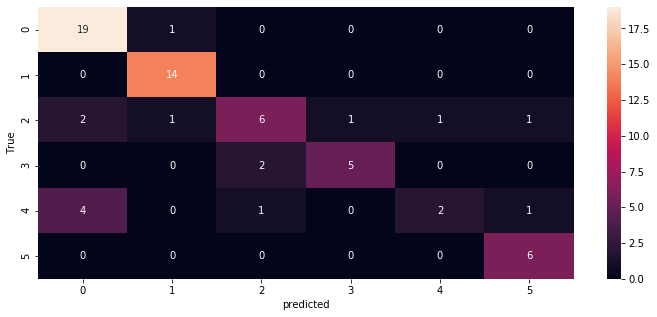

In [27]:
import seaborn as sn
plt.figure(figsize =(12,5))
sn.heatmap(cm, annot=True)
plt.ylabel('True')
plt.xlabel('predicted')

In [28]:
import joblib
joblib.dump(best_model, 'fav_footy_face_model.pkl')


['fav_footy_face_model.pkl']

In [29]:
import json
with open ('class_dict.json', 'w') as f:
    f.write(json.dumps(class_dict))